In [2]:
################# Hierarchical Graph Learning ######################
"""
Algorithm: Coarsened S2
Author: Shivakshit Patri
"""
import matplotlib.pyplot as plt
import cugraph as cnx
import networkx as nx
import numpy as np
import random
import imageio
import glob
import os
import ipywidgets as widgets
from IPython.display import display

In [3]:
class Graph():                                                                                      # Class to create a synthetic grid graph data for testing purposes.
    def create_graph(self, rows = 10, columns = 10):                                                # This function is designed for 2D grid graphs.
        G = nx.grid_2d_graph(rows, columns)                                                         # Creating a 2D grid graph using networkx.
        node_labels = self.define_labels(G, rows, columns)                                          # Defining node labels using define_labels function.
        pos = dict((n, n) for n in G.nodes())                                                       # Defining the 'pos' attribute of nodes for display purposes.
        for (i,j) in list(node_labels):                                                             # Iterating over all nodes.
            G.node[(i,j)]['pos'] = pos[(i, j)]                                                      # Assigning the 'pos' attribute for each node.
            G.node[(i,j)]['label'] = node_labels[(i, j)]                                            # Assigning the 'label' attribute for each node
        return G                                                                                    # Returning the constructed graph
        
    def define_labels(self, G, rows = 10, columns = 10):                                            # Function to create a dictionary containing the labels of the nodes.
        transition = int(columns/2)                                                                 # Default transition value is set to the midway of number of columns.
        node_labels = dict(((i, j), 1 if i < transition else 0) for i, j in G.nodes())              # Node labels are defined as a dictionary. Labels are binary.
        return node_labels                                                                          # Returning the node labels dictionary.
    
def display_graph(G, color_map = []):                                                               # Function to display grid graph created using Graph class.
    pos = nx.get_node_attributes(G,'pos')                                                           # Extracting 'pos' attribute from the graph.
    node_labels = nx.get_node_attributes(G,'label')                                                 # Extracting node labels from the graph.
    if color_map == []:                                                                             # Creating a color map for nodes if it doesnt exist already.
        color_map = {key:'orange' if node_labels[key] == 0
                     else 'yellow' for key in node_labels.keys()}                                   # Assigning the colors for the nodes based on the node label.
    nx.draw_networkx(G, pos = pos, labels = node_labels, edge_color = 'white',
                     node_color = color_map.values(), node_size = 150)                              # Displaying the graph.
    plt.axis('off')
    plt.show()

/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


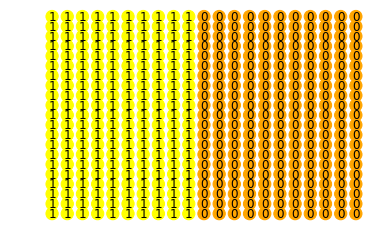

In [4]:
gg = Graph()                                                                                        # Creating an object of the graph generating class.
g0 = gg.create_graph(rows=21, columns=21)                                                           # Returning a graph object generated by the create_graph function.
display_graph(G = g0)                                                                               # Displaying the generated graph.

In [7]:
def domination(G, r, hint_set, selection_set):
    all_nodes = set(G.nodes())
    hint_neighbors = set()
    for node in hint_set:
        hint_neighbors.update(set(nx.single_source_shortest_path_length(G, node, cutoff=r).keys()))
    all_nodes = all_nodes - hint_neighbors
    selection_set = selection_set - hint_neighbors
    node_neighbors = set()
    domination_set = set()
    while len(all_nodes) > 0 and len(selection_set) > 0:
        node = random.sample(selection_set, k=1)[0]
        selection_neighbors = set(nx.single_source_shortest_path_length(G, node, cutoff=r).keys())
        all_nodes = all_nodes - selection_neighbors
        selection_set = selection_set - selection_neighbors
        domination_set.add(node)
    return len(all_nodes), hint_set, domination_set

def hierarchy(G, r0 = 1, hint_set = set()):
    r = r0
    domination_set = set(G.nodes())
    h = []
    while len(domination_set) > 0:
        isDomination, hs, ds = domination(G, r, hint_set, domination_set)
        if (isDomination)==0:
            hint_set, domination_set = hs, ds
            #print(domination_set)
            print(r)
            print(domination_set)
        r += 1
    return h
h = hierarchy(g0, 1, ((1, 1), (6, 6)))


1
{(7, 3), (19, 19), (11, 11), (16, 9), (12, 12), (20, 20), (18, 4), (3, 7), (11, 5), (12, 6), (0, 17), (15, 11), (14, 1), (13, 7), (20, 9), (19, 3), (18, 9), (15, 4), (13, 20), (20, 4), (18, 20), (8, 15), (3, 2), (2, 6), (9, 14), (8, 2), (9, 3), (6, 0), (4, 16), (7, 5), (14, 15), (19, 13), (1, 12), (2, 11), (11, 15), (14, 8), (13, 0), (19, 8), (18, 0), (17, 8), (15, 13), (16, 16), (3, 17), (12, 2), (17, 6), (14, 5), (1, 16), (15, 0), (20, 0), (1, 5), (18, 16), (0, 11), (8, 6), (4, 1), (10, 9), (9, 7), (5, 4), (10, 4), (9, 20), (7, 1), (14, 19), (5, 17), (19, 17), (10, 19), (15, 7), (0, 8), (4, 11), (5, 10), (4, 6), (5, 7), (11, 3), (16, 1), (14, 12), (12, 4), (11, 20), (17, 12), (16, 20), (14, 3), (13, 9), (20, 15), (19, 1), (17, 17), (3, 15), (8, 13), (2, 8), (8, 0), (5, 13), (8, 19), (9, 18), (16, 14), (19, 11), (1, 20), (17, 15), (7, 20), (20, 12), (0, 15), (3, 10), (1, 14), (10, 0), (11, 13), (7, 14), (6, 18), (14, 10), (18, 2), (17, 10), (2, 3), (1, 9), (16, 5), (6, 8), (11, 8), 

In [6]:
def label_completion(G, L):                                                                         # Label completetion algorithm adapted from ZLG.
    queried_id = L
    queried_labels = np.array([G.nodes[id]['label'] for id in queried_id])
    unqueried_id = list(G.nodes - queried_id)
    node_list = queried_id + unqueried_id
    wt = nx.adjacency_matrix(G, nodelist=node_list)
    wt = wt.todense()
    wt = np.array(wt)
    d_vec = np.sum(wt, axis= 0 ,keepdims=False)
    D_inv = np.diag(1./d_vec)
    P = np.matmul(D_inv, wt)
    I = np.eye(len(unqueried_id))
    v1 = np.linalg.inv(I - P[len(queried_id):, len(queried_id):])
    v2 = np.matmul(P[len(queried_id):, 0:len(queried_id)], queried_labels)
    f_u = np.matmul(v1, v2)
    f_u[np.where(f_u >= 0.5)] = 1
    f_u[np.where(f_u < 0.5)] = 0
    for i in range(len(unqueried_id)):
        G.node[unqueried_id[i]]['label'] = int(f_u[i])
    return G

In [ ]:
def traditional_s2(G, budget, L = {}, performance=[], evaluate=True, vizualize = True, snps=0):     # S2 algorithm adapted from Dasarathy et al.
    G2 = G.copy()                                                                                   # Creating a copy of the graph as the graphs are parse by reference.
    while(True):                                                                                    # 
        query = random.sample(list(set(G.nodes())-set(L.keys())), k=1)[0]                           #
        while(True):
            L[query] = G.node[query]['label']
            if evaluate:
                G_pred = label_completion(G2.copy(), list(L.keys()))
                #gg.draw_graph(G_pred)
                performance.append(iou(G, G_pred))
            if vizualize:
                snps += 1
                snapshot(G, L, snps)
            for node in L.keys():
                if G.has_edge(query,node) and G.node[query]['label'] != G.node[node]['label']:
                    G.remove_edge(query,node)
                    if vizualize:
                        snps += 1
                        snapshot(G, L, snps)
            if len(L.keys()) == len(G.nodes()) or len(L.keys()) == budget:
                return G, L, performance
            query = mssp(G, L)
            if query == None:
                break

def mssp(G, L):
    shortest_shortest_path_length = len(G.nodes())
    shortest_shortest_path = []
    for u in filter(lambda w: L[w] == 0, L.keys()):
        for v in filter(lambda w: L[w] == 1, L.keys()):
            if nx.has_path(G,u,v):
                if nx.shortest_path_length(G, u, v) < shortest_shortest_path_length:
                    shortest_shortest_path = nx.shortest_path(G, u, v)
                    shortest_shortest_path_length = len(shortest_shortest_path)
    if shortest_shortest_path != []:
        mid_node = shortest_shortest_path[int(shortest_shortest_path_length/2)]
    else:
        mid_node = None
    return mid_node

def iou(G, G_pred):
    label1 = np.array(list(nx.get_node_attributes(G,'label').values()))
    label2 = np.array(list(nx.get_node_attributes(G_pred,'label').values()))
    return np.logical_and(label1,label2).sum()/np.logical_or(label1, label2).sum()

def snapshot(G, L, snps):
    pos = nx.get_node_attributes(G,'pos')
    node_labels = nx.get_node_attributes(G,'label')
    color_map = {key:'gray' for key in node_labels.keys()}
    for key in L.keys():
        if node_labels[key] == 1:
            color_map[key] = 'yellow'
        else:
            color_map[key] = 'orange'
    nx.draw_networkx(G, pos = pos, labels = node_labels, edge_color = 'blue', node_color = color_map.values(), node_size = 80)
    plt.title("Snap Number: " + str(snps))
    plt.savefig(os.path.join(image_path.value, str(snps) + '.png'), format='png')
    plt.axis('off')
    plt.show()

def display_run(gif_path=gif_path.value, image_path=image_path.value, gif_name='s2_run.gif', image_format='png'):
    with imageio.get_writer(os.path.join(gif_path, gif_name), mode='I', duration=1) as writer:
        filenames = glob.glob(image_path+'/*.' + image_format)
        filenames = sorted(filenames, key=lambda s: int((os.path.splitext(s)[0]).split('/')[-1]))
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    display(Image(url=os.path.join(gif_path, gif_name)))